# Basic imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

In [2]:
# df_all = pd.read_csv('test/df_all.tsv', sep='\t')
df_all_small = pd.read_csv('test/df_all_small.tsv', sep='\t')
learning_df = pd.read_csv('test/learning_df.tsv', sep='\t')
# results = load('test/results.joblib')
results_small = load('test/results_small.joblib')

In [3]:
df_all_small.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,group_code,y,0,1
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae,41,1,0.870,0.130
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae,41,1,0.730,0.270
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae,41,1,0.805,0.195
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae,41,1,0.875,0.125
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae,41,1,0.800,0.200


In [4]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

logo = LeaveOneGroupOut()
X_main = df_all_small.drop(['virus', 'host', 'group', 'group_code', 'y', '0', '1'], axis=1)
y_main = df_all_small['y']
groups_main = df_all_small['group_code'].values

# Visualisation functions declarations

Necessary imports

In [5]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve, auc, roc_curve

Detailed ROC for singular model

In [6]:
# Classification and ROC analysis
def draw_roc_cv(df_to_draw, est_name):
    # Run classifier with cross-validation and plot ROC curves
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(20, 20))
    for i, (train, test) in enumerate(logo.split(X_main, y_main, groups=groups_main)):
        viz = RocCurveDisplay.from_predictions(
            y_true=df_to_draw.loc[test, 'y'],
            y_pred=df_to_draw.loc[test, '1'],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=f"{est_name} - ROC curve",
    )
    ax.legend(loc="lower right")
    plt.show()


ROC curve for multiple models

In [7]:
def draw_rocs(dfs, names):
    plt.figure(figsize=(12, 7))
    for i, df in enumerate(dfs):
        fpr, tpr, thresh = roc_curve(df['y'], df['1'])
        plt.plot(fpr, tpr, label=f'AUC ({names[i]}) = {auc(fpr, tpr):.2f}')

    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    plt.title('ROC Curve', size=20)
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend()

Precision-recall curve

In [8]:
def draw_precision_recall_curve(dfs, names):
    plt.figure(figsize=(12, 7))
    ax = plt.gca()
    for i, df in enumerate(dfs):
        color = next(ax._get_lines.prop_cycler)['color']
        precision, recall, thresholds = precision_recall_curve(df['y'], df['1'])
        auc_temp = auc(recall, precision)
        f1_scores = 2*recall*precision/(recall+precision)
        index = np.argmax(f1_scores)

        line = plt.plot(recall, precision, label=f'AUC ({names[i]}) = {auc_temp:.2f}', color=color)
        plt.plot(recall[index], precision[index], marker='o', color=color) # marker
        plt.text(recall[index], precision[index]+(0.03 if i%2 == 0 else -0.05), \
             f'x={recall[index]:.2f}, y={precision[index]:.2f}', color=color)
    plt.title('Precision-Recall Curve', size=20)
    plt.xlabel('Recall', size=14)
    plt.ylabel('Precision', size=14)
    plt.legend()

Gini importances histogram

In [9]:
def draw_gini_importances(importances, std, X):
    forest_importances = pd.Series(importances, index=X.columns)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

# pandas-profiling

In [ ]:
# !!! requires Pandas 1.3.5 - incompatible with >= 1.4.0 because of indexing !!!
'''
from pandas_profiling import ProfileReport
profile = ProfileReport(df_all_small.drop(['0', '1'], axis=1), title='Bacteriophage interactions (Edwards) dataset')
profile.to_file('Edwards_analysis.html')
'''

# Feature selection

## Determining multicollinearity

#### VIF - Variance Inflation Factor

Define the vif function

In [42]:
# Compute VIF data for each independent variable (considered high if > 10)
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(features: list):
    features.append('y')
    df_chosen = df_all_small[features]
    vif = pd.DataFrame()
    vif["features"] = df_chosen.columns
    vif["vif_Factor"] = [variance_inflation_factor(df_chosen.values, i) \
                        for i in range(df_chosen.shape[1])]
    features.remove('y')
    return vif

In [43]:
feats = list(X_main.columns)
print(calculate_vif(feats))

                 features  vif_Factor
0                  blastn    8.871166
1  crisprdetect-2mismatch    6.662138
2              gc_content   33.401111
3                     k25    8.853917
4            k6-chebyshev    4.177338
5           k6-kendalltau   54.389713
6            k6-manhattan  129.992448
7         piler-2mismatch    6.658734
8                    wish   23.329448
9                       y    1.160475


## Variable selection

### Simple selection - minimal set 

In [44]:
feats = ['blastn', 'gc_content', 'k6-chebyshev']
print(calculate_vif(feats))

       features  vif_Factor
0        blastn    1.127404
1    gc_content    2.668067
2  k6-chebyshev    2.669262
3             y    1.128129


Train model on selected features - function declaration

In [14]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

results_dfs = {}

def train_model_on_features(features: list, name: str, n_est=200):
    # get X and y
    X_selected = learning_df[features]
    y_selected = learning_df['y']
    groups = learning_df['group_code'].to_numpy()

    # train the model
    # determine the scoring method
    scoring = ['f1']
    # create logo cv procedure
    logo = LeaveOneGroupOut()
    # create model
    rfc = RandomForestClassifier(n_estimators = n_est, criterion = 'entropy', random_state=1)
    # evaluate model
    results_selected = cross_validate(rfc, X_selected, y_selected, scoring=scoring, 
                            cv=logo, groups=groups, n_jobs=-1, return_estimator=True)

    # get the probabilities
    X_sel_main = df_all_small[features]
    prob_df_sel = pd.DataFrame(index=range(len(df_all_small['y'])), columns=['0', '1'])
    prob_df_sel['0'] = prob_df_sel['0'].astype('float')
    prob_df_sel['1'] = prob_df_sel['1'].astype('float')
    for i in range(0, max(groups_main)+1):
        mask_main = groups_main == i
        prob_df_sel.loc[mask_main, ['0', '1']] = \
            results_selected['estimator'][i].predict_proba(X_sel_main.loc[mask_main,:])

    # append the dataframe to results dict
    results_dfs[name] = pd.concat([df_all_small['y'], prob_df_sel], axis=1)
    return

Train the model on minimal set

In [15]:
feats = ['blastn', 'gc_content', 'k6-chebyshev']
train_model_on_features(feats, 'minimal')

In [16]:
results_dfs['minimal'].head()

,y,0,1
0,1,0.155,0.845
1,1,0.365,0.635
2,1,0.105,0.895
3,1,0.200,0.800
4,1,0.105,0.895


Visualise differences

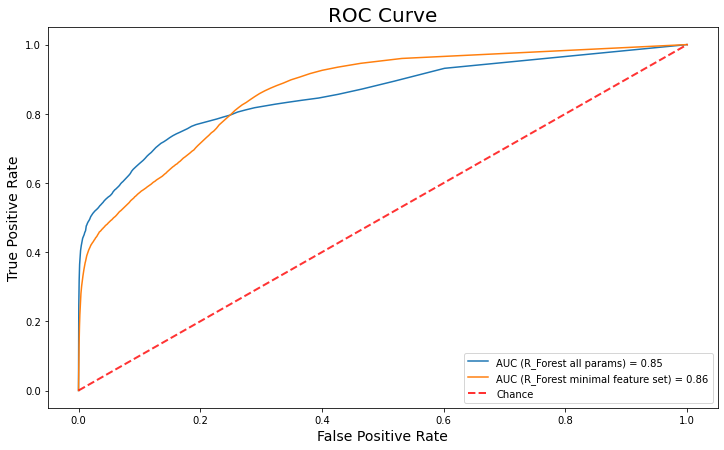

In [17]:
draw_rocs([df_all_small, results_dfs['minimal']], \
    ['R_Forest all params', 'R_Forest minimal feature set'])

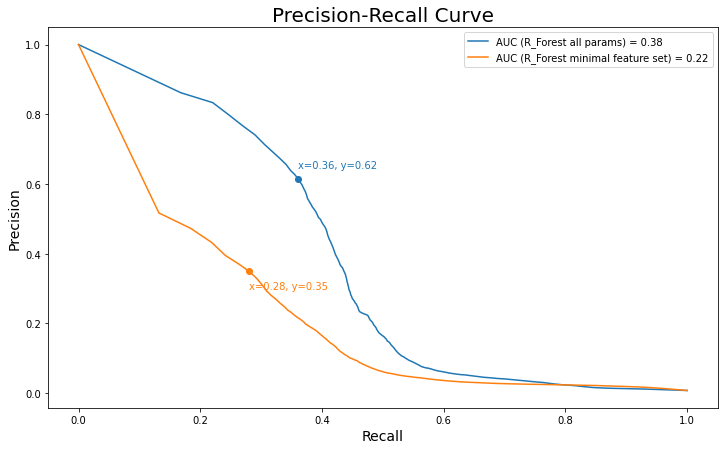

In [18]:
draw_precision_recall_curve([df_all_small, results_dfs['minimal']], \
    ['R_Forest all params', 'R_Forest minimal feature set'])

### Advanced selection

#### 1. Determine n feats with highest corr to label

In [45]:
corrs = X_main.corrwith(df_all_small['y']).abs().sort_values(ascending=False)
corrs

k25                       0.334636
blastn                    0.333629
crisprdetect-2mismatch    0.118987
piler-2mismatch           0.116918
k6-manhattan              0.099880
wish                      0.094791
k6-kendalltau             0.087376
gc_content                0.083626
k6-chebyshev              0.055518
dtype: float64

In [46]:
feats = list(corrs.index[0:4])

Check for multicollinearity

In [49]:
calculate_vif(feats)

,features,vif_Factor
0,k25,8.828372
1,blastn,8.831366
2,crisprdetect-2mismatch,6.661896
3,piler-2mismatch,6.658685
4,y,1.144898


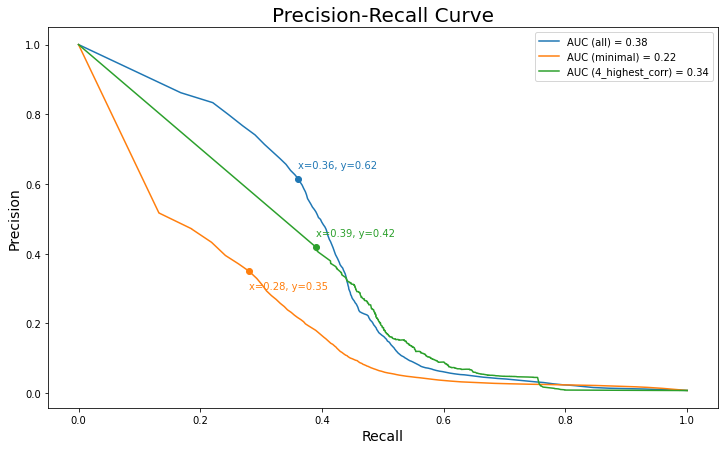

In [50]:
train_model_on_features(feats, '4_highest_corr')
draw_precision_recall_curve([df_all_small, results_dfs['minimal'], results_dfs['4_highest_corr']], ['all', 'minimal', '4_highest_corr'])

#### 2. Determine n feats with highest Gini index

Get Gini indices

In [51]:
importances = np.array([results_small['estimator'][i].feature_importances_ for i in range(0, max(df_all_small['group_code']))])

In [52]:
stds = []
for i in range(0, max(df_all_small['group_code'])):
    stds.append(np.std([tree.feature_importances_ for tree in results_small['estimator'][i].estimators_], axis=0))
stds = np.array(stds)

Calculate means of importances

In [53]:
importances_means = np.mean(importances, axis=0)
stds_means = np.mean(stds, axis=0)

Plot the mean importances

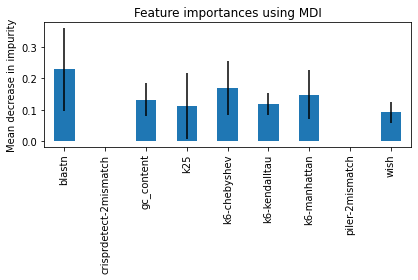

In [54]:
draw_gini_importances(importances_means, stds_means, X_main)

Get the feats

In [55]:
pd.Series(data=importances_means, index=X_main.columns).sort_values(ascending=False)

blastn                    0.228954
k6-chebyshev              0.169987
k6-manhattan              0.147494
gc_content                0.132441
k6-kendalltau             0.117227
k25                       0.112187
wish                      0.091193
crisprdetect-2mismatch    0.000308
piler-2mismatch           0.000209
dtype: float64

In [58]:
feats = list(pd.Series(data=importances_means, index=X_main.columns).sort_values(ascending=False).index)[0:4]

In [59]:
calculate_vif(feats)

,features,vif_Factor
0,blastn,1.127520
1,k6-chebyshev,3.029060
2,k6-manhattan,14.446460
3,gc_content,12.725326
4,y,1.134156


Train the model on feats

In [60]:
train_model_on_features(feats, '4_highest_gini')

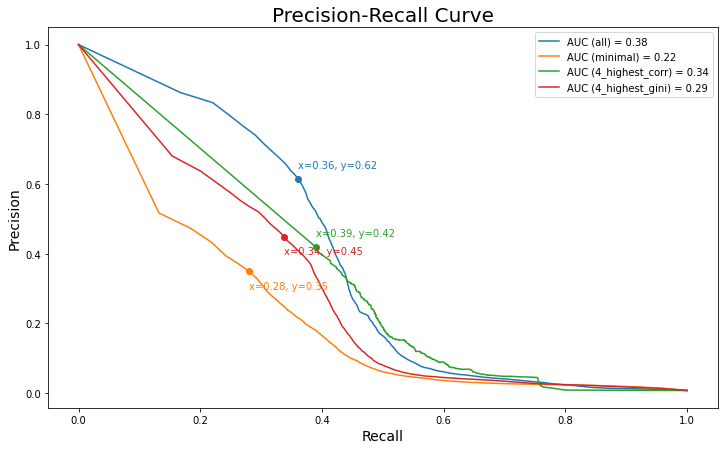

In [61]:
draw_precision_recall_curve([df_all_small, results_dfs['minimal'], results_dfs['4_highest_corr'], results_dfs['4_highest_gini']],\
                             ['all', 'minimal', '4_highest_corr', '4_highest_gini'])

#### 3. Determine n feats with highest SHAP values

## PCA

In [62]:
from scipy.stats import shapiro
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA
def get_pca(X, df, components: int):
    # check for normal distribution and scale appropriately
    X_pca = Normalizer().fit_transform(X) if shapiro(X)[1] < 0.05 else StandardScaler().fit_transform(X)
    # perform PCA
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(X_pca)
    cols = [f'component {i+1}' for i in range(0, components)]
    principal_df = pd.DataFrame(data=X_pca, columns=cols)
    return pd.concat([principal_df, df['y']], axis=1)

In [63]:
pca_df = get_pca(X_main, df_all_small, 2)

c:\licencjat\test_env\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Visualize PCA

In [64]:
def draw_pca_2d(df):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0, 1]
    colors = ['r', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = df['y'] == target
        ax.scatter(df.loc[indicesToKeep, 'component 1'], 
                    df.loc[indicesToKeep, 'component 2'], 
                    c = color, s = 50)
    ax.legend(targets)
    ax.grid()

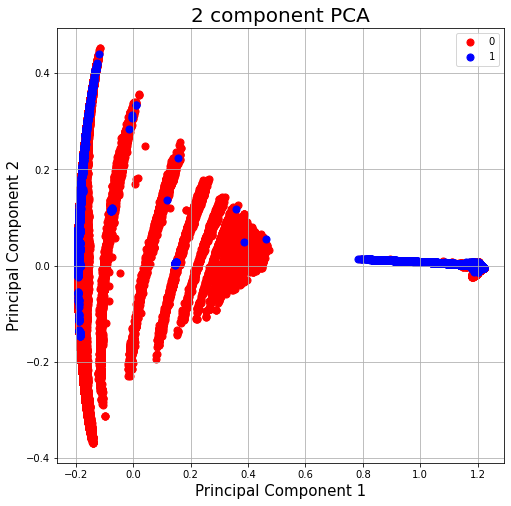

In [65]:
draw_pca_2d(pca_df)

In [16]:
from mpl_toolkits.mplot3d import Axes3D
def draw_pca_3d(df):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1, projection='3d') 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_zlabel('Principal Component 3', fontsize = 15)
    ax.set_title('3 component PCA', fontsize = 20)
    targets = [0, 1]
    colors = ['r', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = df['y'] == target
        ax.scatter(df.loc[indicesToKeep, 'component 1'], 
                    df.loc[indicesToKeep, 'component 2'], 
                    df.loc[indicesToKeep, 'component 3'], 
                    c = color, s = 50)
    ax.legend(targets)
    ax.grid()

c:\licencjat\test_env\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


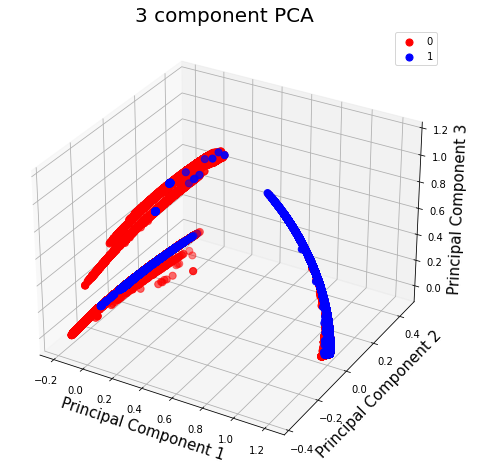

In [17]:
draw_pca_3d(get_pca(X_main, df_all, 3))

In [18]:
def train_model_on_pca(X: pd.DataFrame, df: pd.DataFrame, name: str, comps, n_est=200):
    df_after_pca = get_pca(X, df, components=comps)
    # get X and y
    X_selected = df_after_pca.drop(['y'], axis=1)
    y_selected = df_after_pca['y']
    groups = df['group_code'].to_numpy()

    # train the model
    # determine the scoring method
    scoring = ['f1']
    # create logo cv procedure
    logo = LeaveOneGroupOut()
    # create model
    rfc = RandomForestClassifier(n_estimators = n_est, criterion = 'entropy', random_state=1)
    # evaluate model
    results_selected = cross_validate(rfc, X_selected, y_selected, scoring=scoring, 
                            cv=logo, groups=groups, n_jobs=-1, return_estimator=True)

    # get the probabilities
    X_sel_main = get_pca(X_main, df_all, components=comps).drop(['y'], axis=1)
    prob_df_sel = pd.DataFrame(index=range(len(df_all['y'])), columns=['0', '1'])
    prob_df_sel['0'] = prob_df_sel['0'].astype('float')
    prob_df_sel['1'] = prob_df_sel['1'].astype('float')
    for i in range(0, max(groups_main)+1):
        mask_main = groups_main == i
        prob_df_sel.loc[mask_main, ['0', '1']] = \
            results_selected['estimator'][i].predict_proba(X_sel_main.loc[mask_main,:])

    # append the dataframe to results dict
    results_dfs[name] = pd.concat([df_all['y'], prob_df_sel], axis=1)
    return

In [19]:
X_learn = learning_df.drop(['virus', 'host', 'group', 'group_code', 'y'], axis=1)
train_model_on_pca(X_learn, learning_df, 'pca_2d', 2)

c:\licencjat\test_env\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\licencjat\test_env\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


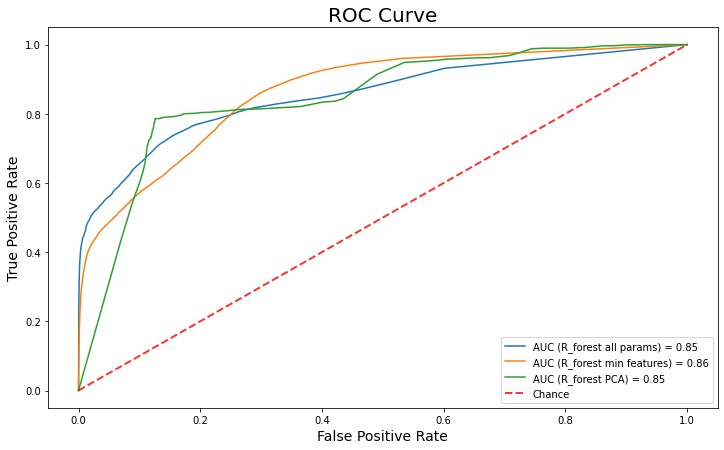

In [20]:
draw_rocs([df_all_small, results_dfs['minimal'], results_dfs['pca_2d']], ['R_forest all params', 'R_forest min features', 'R_forest PCA'])

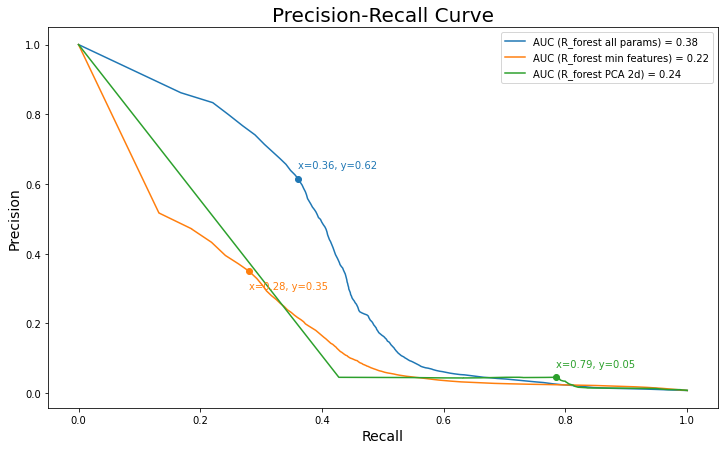

In [21]:
draw_precision_recall_curve([df_all_small, results_dfs['minimal'], results_dfs['pca_2d']], ['R_forest all params', 'R_forest min features', 'R_forest PCA 2d'])

c:\licencjat\test_env\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\licencjat\test_env\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


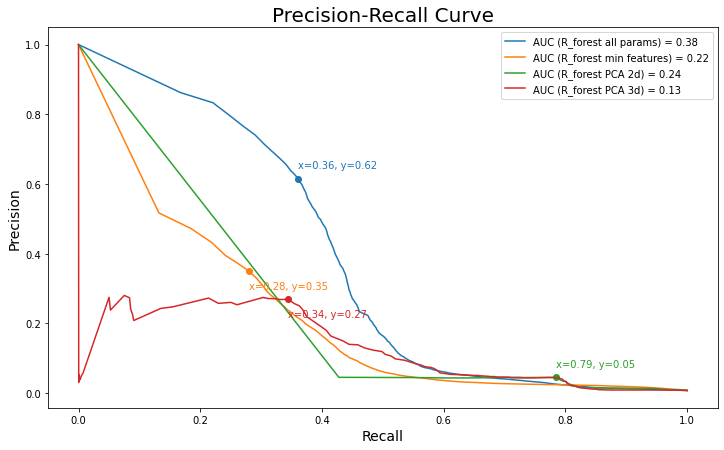

In [22]:
train_model_on_pca(X_learn, learning_df, 'pca_3d', 3)
draw_precision_recall_curve([df_all_small, results_dfs['minimal'], results_dfs['pca_2d'], results_dfs['pca_3d']],\
    ['R_forest all params', 'R_forest min features', 'R_forest PCA 2d', 'R_forest PCA 3d'])